In [1]:
# Setup code

import sys

prefix = ".."
sys.path.insert(0, prefix)

import datetime
#import skdim
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import pickle
import re
#from sklearn.decomposition import PCA
import ipywidgets as widgets

from torch.utils.data import DataLoader

import trainers
import utils

%matplotlib widget
plt.rcParams["figure.figsize"] = (7, 3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
basedir = "../.."

KeyboardInterrupt: 

In [8]:
config

{'__object__': {'path': 'models.autoencoder.ae', 'name': 'FCAutoEncoder', 'args': 'as_config'}, 'sample': {'spatial_resolution': 1024, 'latents_dims': 2}, 'downblocks': {'widths': [1024, 128, 128, 128, 2], 'actvn': 'relu'}}

In [23]:
from common.config import load_config, create_object

# loss and logging info accu
config = load_config(f"{prefix}/models/autoencoder/configs/fc_ae.yaml")


print(config)

{'__object__': {'path': 'models.autoencoder.ae', 'name': 'FCAutoEncoder', 'args': 'as_config'}, 'sample': {'spatial_resolution': 1024, 'latents_dims': 2}, 'downblocks': {'widths': [128, 128, 128], 'actvn': 'relu'}}


In [6]:
model

FCAutoEncoder(
  (encoder): FCEncoder(
    (blocks): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1024, out_features=128, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (3): Linear(in_features=128, out_features=2, bias=True)
    )
  )
  (decoder): FCDecoder(
    (blocks): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
      )
      (2): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (3): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )

In [ ]:
def create_error_tabledict(errors, labels, transposed=False):
  if transposed:
    num_cols = len(labels)

    table = "\\begin{table}[h]\n\\centering\n"
    table += "\\begin{tabular}{|" + "r|" * (num_cols + 1) + "}\n"
    table += "\\hline\n"
    table += "& " + " & ".join([str(label) for label in labels]) + " \\\\\n\\hline\n"

    for row_name, row_values in errors.items():
        table += row_name + " & " + " & ".join([f"{val*100:.2f}" for val in row_values]) + " \\\\\n\\hline\n"

    table += "\\end{tabular}\n"
    table += "\\end{table}"
    return table
  
  else:
    columns = list(errors.keys())
    num_cols = len(columns)

    table = "\\begin{table}[h]\n\\centering\n"
    table += "\\begin{tabular}{|" + "r|" * (num_cols + 1) + "}\n"
    table += "\\hline\n"
    table += "& " + " & ".join([str(col) for col in columns]) + " \\\\\n\\hline\n"

    for label, col_values in zip(labels, zip(*[errors[col] for col in columns])):
        table += str(label) + " & " + " & ".join([f"{val*100:.2f}" for val in col_values]) + " \\\\\n\\hline\n"

    table += "\\end{tabular}\n"
    table += "\\end{table}"
    return table

def create_error_table(errors, labels):
    num_cols = max(len(row) for row in errors)

    table = "\\begin{table}[h]\n\\centering\n"
    table += "\\begin{tabular}{|" + "r|" * (num_cols + 1) + "}\n"
    table += "\\hline\n"

    table += "& " + " & ".join([str(i + 1) for i in range(num_cols)]) + " \\\\\n\\hline\n"

    for label, row in zip(labels, errors):
        table += str(label) + " & " + " & ".join([f"{val*100:.2f}" for val in row]) + " \\\\\n\\hline\n"

    table += "\\end{tabular}\n"
    table += "\\end{table}"

    return table

In [7]:
estimator = skdim.id.TwoNN()

dataset = utils.DynamicData((f"{basedir}/datasets/burgers/grfarc2visc0p001-coeffs.mat", "grfarc2visc0p001"))

for problem in ["kdv", "burgers", "transport"]:
  if problem == "burgers":
    dataset = utils.DynamicData((f"{basedir}/datasets/burgers/grfarc2visc0p001-coeffs.mat", "grfarc2visc0p001"))
  elif problem == "kdv":
    dataset = utils.DynamicData((f"{basedir}/datasets/kdv/kdv2.mat", "kdv2wide"))
  elif problem == "transport":
    dataset = utils.DynamicData((f"{basedir}/datasets/transport/hats2_2500.mat", "alldata"))

  dataset.shuffle_inplace()

  dataset.downsample(dataset.data.shape[2] // 512)
  dataset.scaledown()

  print(problem, estimator.fit(dataset.data[:, 0, :]).dimension_)

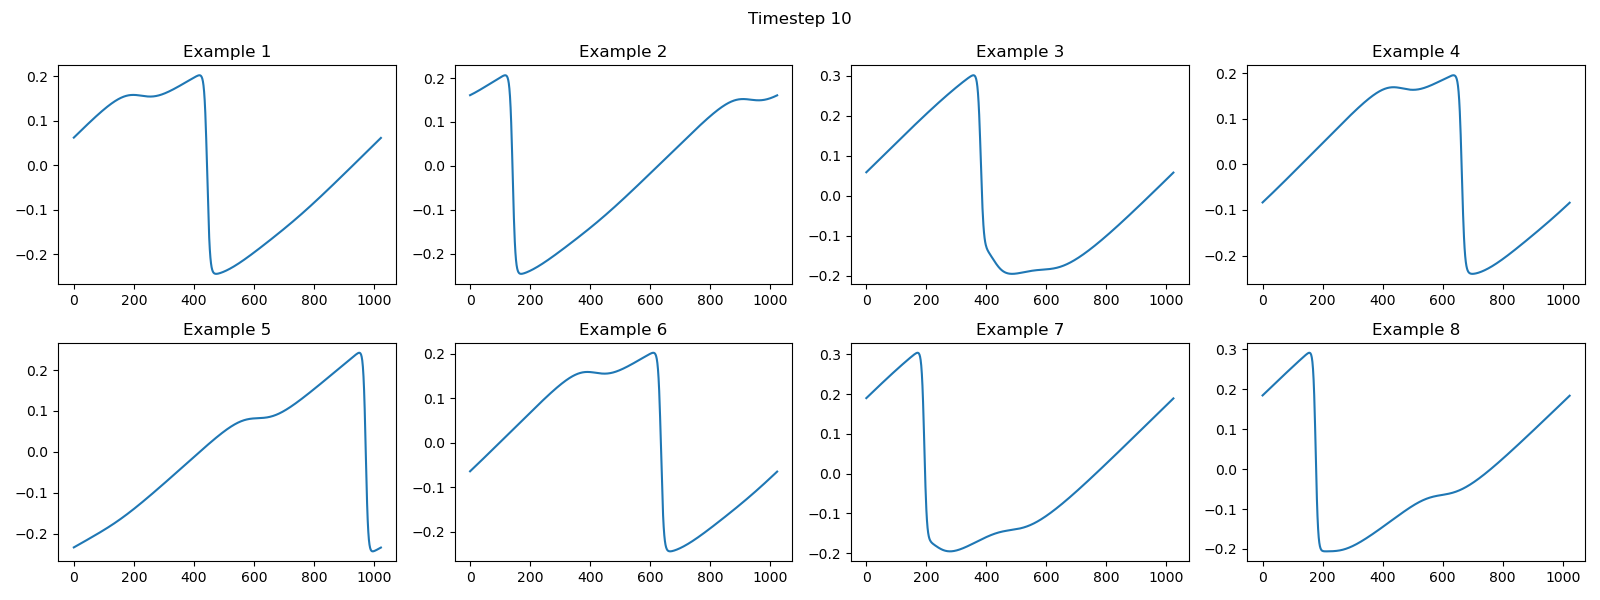

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

def video_data(arr):
  N, T, M = arr.shape
  indices = np.random.choice(N, size=8, replace=False)

  fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6))

  padding = 8
  def update(frame):
      frame = max(frame - padding, 0)
      if frame >= T:
         frame = T-1

      for i, ax in enumerate(axes.flatten()):
          ax.clear()
          ax.plot(arr[indices[i], frame, :])
          ax.set_title(f'Example {i+1}')

      fig.suptitle(f"Timestep {frame}")
      fig.tight_layout()

  ani = animation.FuncAnimation(fig, update, frames=T+2*padding)

  # Save the animation as a video
  ani.save('burgersinitial.gif', writer='ffmpeg')
  return ani

video_data(dataset.data)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Assuming you have your NxTxM array named 'arr'
N, T, M = arr.shape

# Select 4 random indices less than N
indices = np.random.choice(N, size=4, replace=False)

# Create a figure with 1 row and 4 columns
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

# Function to update the plot for each frame
def update(frame):
    for i, ax in enumerate(axes.flatten()):
        ax.clear()
        ax.plot(arr[indices[i], frame, :])
        ax.set_title(f'Example {indices[i]}')

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=T, interval=50, blit=True)

# Save the animation as a video
ani.save('arr_animation.mp4', writer='ffmpeg')

In [31]:
import numpy as np
import scipy.io
import warnings

def hat(x, a, b, alpha):
  def relu(x):
      return np.maximum(x, 0)
    
  return 2 * alpha / (b - a) * (relu(x - a) - 2 * relu(x - (a+b)/2) + relu(x-b))

def ndim_hat(x, a, h, epsilon=0.2):
  product = np.ones(x.shape[0])
  for d in range(x.shape[1]):
    product *= hat(x[:, d], h, h+epsilon, a)

  return product

def generate_twodim_hat_data(num, arange=[0, 3], hrange=[0, 3], trange=[0, 0.3], numt=51, params=True, res=100):
  hvals = hrange[0] + (np.random.rand(num)) * (hrange[1] - hrange[0])
  avals = arange[0] + (np.random.rand(num)) * (arange[1] - arange[0])

  x = np.linspace(0, 1, res)
  y = np.linspace(0, 1, res)

  X, Y = np.meshgrid(x, y)

  input = np.column_stack((X.flatten(), Y.flatten()))
  alldata = np.zeros((num, numt, res, res))
  tvals = np.linspace(trange[0], trange[1], numt)
  for i in range(num):
    for t in range(numt):
      alldata[i, t, :, :] = ndim_hat(input, avals[i] + 1, 0.1*hvals[i] + tvals[t]).reshape(X.shape)

    print(i)

  if params:
    return (alldata, np.column_stack((avals, hvals)))
  else:
    return alldata

alldata, params = generate_twodim_hat_data(10, hrange=[0, 0], res=64)

#scipy.io.savemat("hats2d_scale.mat", {'alldata': alldata, 'params': params})

print(params.shape)

0
1
2
3
4
5
6
7
8
9
(10, 2)


In [32]:
fig,alldata.shape

(10, 51, 64, 64)

In [29]:
dataset.downsample(2)

In [1]:
# Setup code

import datetime
import skdim
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import pickle
import re
from sklearn.decomposition import PCA
import ipywidgets as widgets

from torch.utils.data import DataLoader

import models
import utils

%matplotlib widget
plt.rcParams["figure.figsize"] = (7, 3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = utils.DynamicData(("../datasets/lorenz96/l96_shift.mat", "alldata"))

Using backend: pytorch



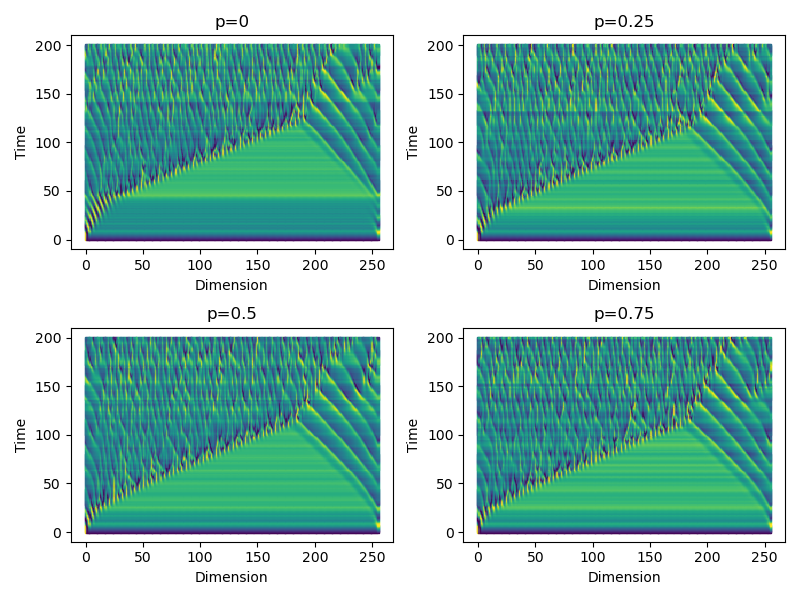

In [20]:
import utils

%matplotlib widget

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = np.reshape(axes, (-1))

ps = [0, 0.25, 0.5, 0.75]
for i in range(len(ps)):
  p = ps[i]
  ax = axes[i]

  alldata = dataset.data
  params = dataset.params

  j = dataset.get_from_params(p)
  x = alldata[j, :, :]
  for i in range(x.shape[0]):
    data = x[i, :]
    ax.scatter(np.arange(len(data)), i * np.ones_like(data), c=data, s=1, marker="s")

  ax.set_xlabel("Dimension")
  ax.set_ylabel("Time")
  ax.set_title(f"p={p}")
  
fig.tight_layout()
plt.savefig("l96-Shift-examples.pdf")

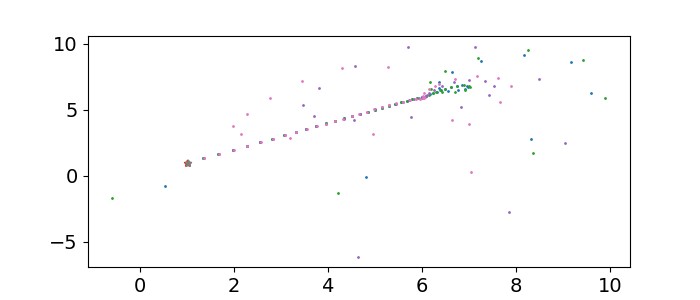

In [55]:
fig = plt.figure()
ax = fig.add_subplot()

num = 4

vals = np.linspace(0, 0.01, num)
positions = [dataset.get_from_params(x) for x in vals]

for i in range(num):
  datas = dataset.data[positions[i], :50, :2]
  ax.scatter(datas[1:, 0], datas[1:, 1], s=1)
  ax.scatter(datas[0:1, 0], datas[0:1, 1], s=20, marker="*")

In [4]:
# code for saving plots of the datasets
datasets = [("../datasets/lorenz96/l96_shift.mat", "alldata")]

labels = ["L96Shift"]

datasets = datasets
labels = labels

errors = []
for i in range(len(labels)):
  currdata = datasets[i]
  dataset = utils.DynamicData(currdata)

  dataset.shuffle_inplace()

  #dataset.downsample(int(dataset.data.shape[2] / 512))
  
  if dataset.data.shape[1] == 101:
    dataset.data = dataset.data[:, ::2, :]

  dataset.scaledown()

  loadstr = labels[i].lower()
  loadstr = re.sub("[^0-9a-zA-Z\s]+", "", loadstr)
  loadstr = re.sub("transport", "hats", loadstr)

  pcak = 10
  error_ts = [utils.get_pca_error(dataset.data[:, t, :], pcak) for t in range(dataset.data.shape[1])]
  print(labels[i])

  errors.append(error_ts)

L96Shift


Reconstruction error 0.6173708267078845


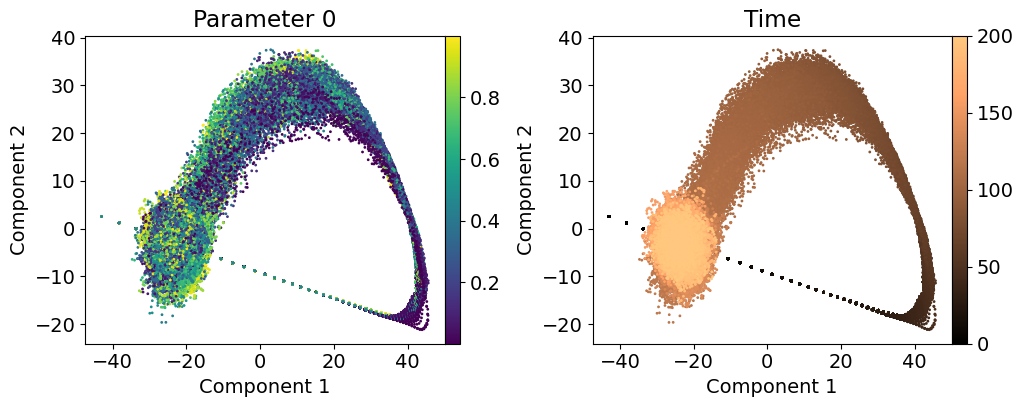

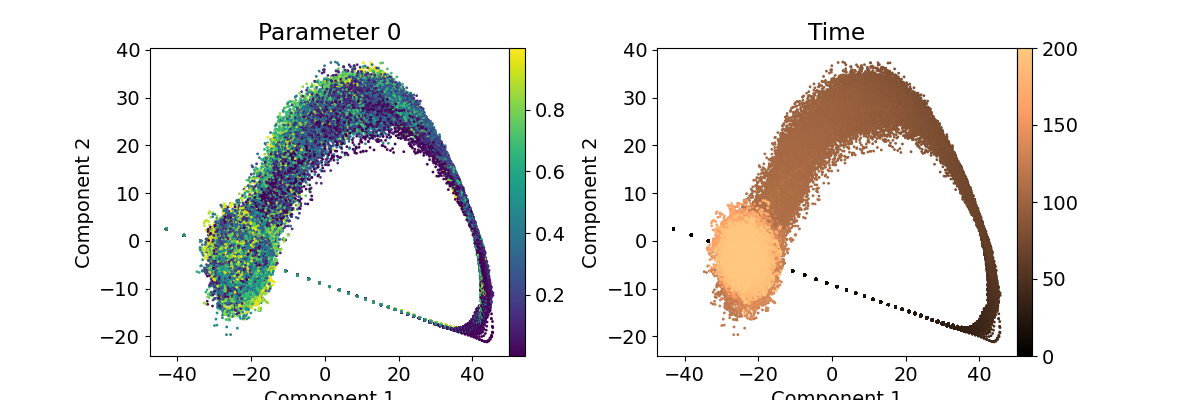

In [24]:
dataset.plot_pca2()

In [11]:
# code for saving plots of the datasets
datasets = [("../datasets/kdv/kdv2-scale.mat", "kdv2wide"), 
            ("../datasets/kdv/kdv2-shift.mat", "kdv2wide"),
            ("../datasets/burgers/grfarc2visc0p001-scale.mat", "grfarc2visc0p001"),
            ("../datasets/burgers/grfarc2visc0p001-shift.mat", "grfarc2visc0p001"),
            ("../datasets/transport/hats2_2500_scale.mat", "alldata"),
            ("../datasets/transport/hats2_2500_shift.mat", "alldata"),
            ("../datasets/ks/ksscaleall.mat", "output"),
            ("../datasets/ks/ksshiftall.mat", "output")]

labels = ["KdV-Scale", "KdV-Shift", "Burgers-Scale", "Burgers-Shift", "Transport-Scale", "Transport-Shift", "KS-Scale", "KS-Shift" ]

datasets = datasets
labels = labels

errors = []
for i in range(len(labels)):
  currdata = datasets[i]
  dataset = utils.DynamicData(currdata)

  dataset.shuffle_inplace()

  if dataset.data.shape[2] == 2048:
    dataset.downsample(4)
  else:
    dataset.downsample(2)

  if dataset.data.shape[1] == 101:
    dataset.data = dataset.data[:, ::2, :]

  dataset.scaledown()

  loadstr = labels[i].lower()
  loadstr = re.sub("[^0-9a-zA-Z\s]+", "", loadstr)
  loadstr = re.sub("transport", "hats", loadstr)

  pcak = 10
  error_ts = [utils.get_pca_error(dataset.data[:, t, :], pcak) for t in range(dataset.data.shape[1])]
  print(labels[i])

  errors.append(error_ts)

KdV-Scale
KdV-Shift
Burgers-Scale
Burgers-Shift
Transport-Scale
Transport-Shift
KS-Scale
KS-Shift


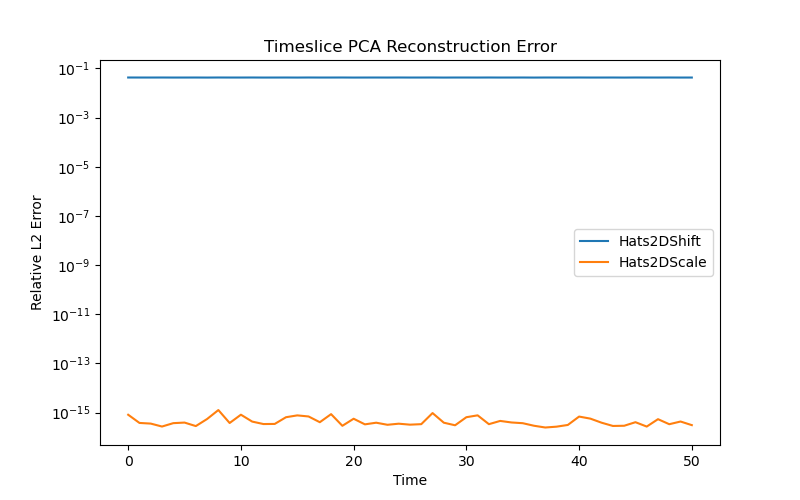

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

for i in range(len(errors)):
  ax.plot(errors[i], label=labels[i])

ax.set_yscale("log")
ax.set_ylabel("Relative L2 Error")
ax.set_xlabel("Time")
ax.set_title("Timeslice PCA Reconstruction Error")
ax.legend()

#fig.savefig("pcaerror.pdf")

interactive(children=(IntSlider(value=0, description='i', max=2499), Output()), _dom_classes=('widget-interact…

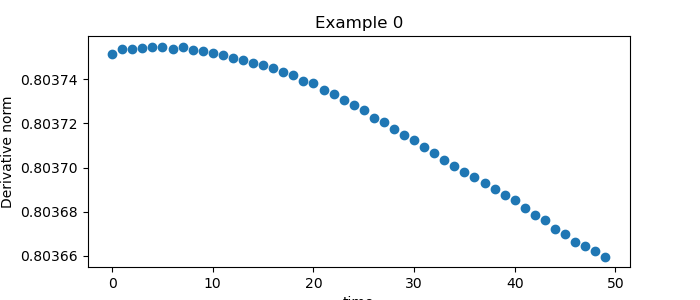

In [8]:
dd = dataset.data
deriv = dd[:, 1:, :] - dd[:, :-1, :]

norms = np.linalg.norm(deriv, axis=2)

fig, ax = plt.subplots()
@widgets.interact(i=(0, norms.shape[0]-1))
def plot(i=0):
  ax.clear()
  ax.scatter(range(norms.shape[1]), norms[i, :])
  ax.set_xlabel("time")
  ax.set_ylabel("Derivative norm")
  ax.set_title("Example " + str(i))


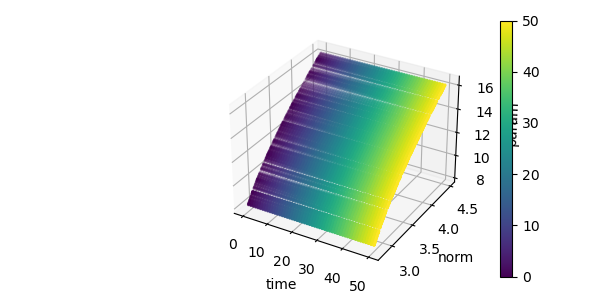

In [11]:
#norms = np.linalg.norm(dataset.data, axis=2)

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(projection="3d")

for i in range(0, norms.shape[0], 10):
  z = sum(dataset.params[i, :]) * np.ones_like(norms[i, :])
  sc = ax.scatter(range(norms.shape[1]), norms[i, :], z, c=range(norms.shape[1]), s=2)

ax.set_xlabel("time")
ax.set_ylabel("norm")
ax.set_zlabel("param")
fig.colorbar(sc, ax=ax)
fig.tight_layout()

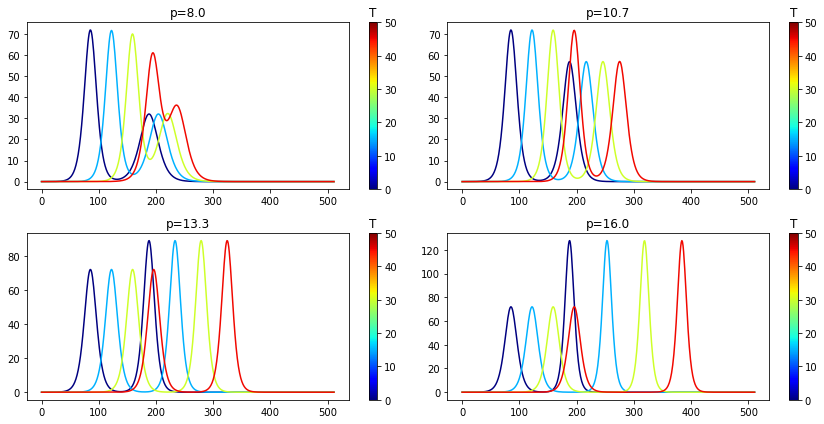

In [50]:
data = dataset.data
num = 4


fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs = axs.ravel()

cmap = plt.cm.get_cmap('jet')
norm = plt.Normalize(vmin=0, vmax=data.shape[1]-1)

for i, p in enumerate(np.linspace(8, 16, num)):
    k = dataset.get_from_params([p, 0])

    ax = axs[i]
    for t in range(0, data.shape[1], 15):
        color = cmap(norm(t))
        ax.plot(data[k, t, :], color=color)

    ax.set_title(f"p={p:.1f}")
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.ax.set_title('T')

fig.tight_layout()
plt.savefig(f"{labels[0]}-examples.pdf")

In [21]:
num_cols = max(len(row) for row in projerrs)

table = "\\begin{table}[h]\n\\centering\n"
table += "\\begin{tabular}{|" + "r|" * (num_cols + 1) + "}\n"
table += "\\hline\n"

table += "& " + " & ".join([str(i + 1) for i in range(num_cols)]) + " \\\\\n\\hline\n"

for label, row in zip(labels, projerrs):
    table += label + " & " + " & ".join([f"{val*100:.2f}" for val in row]) + " \\\\\n\\hline\n"

table += "\\end{tabular}\n"
table += "\\end{table}"

print(table)

\begin{table}[h]
\centering
\begin{tabular}{|r|r|r|r|r|r|r|r|r|r|r|}
\hline
& 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\
\hline
KdV-Scale & 0.24 & 0.49 & 0.52 & 0.53 & 0.49 & 0.59 & 1.26 & 0.98 & 1.22 & 1.04 \\
\hline
KdV-Shift & 0.50 & 0.46 & 0.29 & 0.68 & 0.34 & 0.37 & 0.58 & 0.23 & 1.11 & 0.29 \\
\hline
Burgers-Scale & 0.46 & 0.60 & 0.91 & 0.43 & 1.03 & 0.51 & 0.76 & 0.59 & 0.83 & 0.62 \\
\hline
Burgers-Shift & 3.76 & 2.25 & 1.81 & 1.36 & 3.90 & 1.62 & 1.09 & 1.24 & 1.02 & 2.08 \\
\hline
Transport-Scale & 0.84 & 0.41 & 1.01 & 0.69 & 1.04 & 0.81 & 0.58 & 0.36 & 0.54 & 0.42 \\
\hline
Transport-Shift & 3.48 & 3.15 & 2.61 & 2.80 & 2.79 & 4.05 & 2.58 & 1.95 & 1.90 & 2.04 \\
\hline
\end{tabular}
\end{table}


In [ ]:
print("Dimension of all times together")
alltimes, _ = dataset.collect_times()
print(skdim.id.MLE().fit(alltimes).dimension_)

print("Dimension of time slices")
for i in range(dataset.data.shape[1]):
  print(i, skdim.id.MLE().fit(dataset.data[:, i, :]).dimension_)

Using backend: pytorch



interactive(children=(IntSlider(value=1999, description='j', max=3999), IntSlider(value=0, description='t0', m…

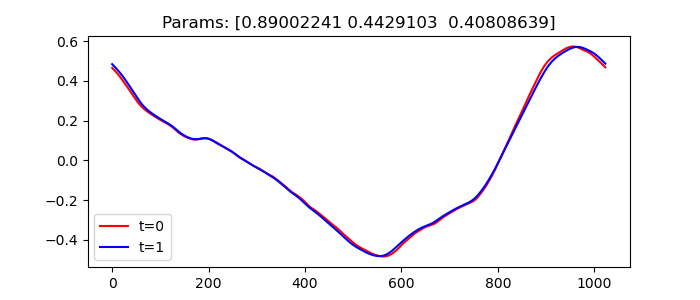

In [1]:
# Setup code

import datetime
import skdim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import pickle
from sklearn.decomposition import PCA
import ipywidgets as widgets

import models
import utils

%matplotlib widget

plt.rcParams["figure.figsize"] = (7, 3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = utils.DynamicData(("../datasets/burgers/grfarc2visc0p001-threeparam.mat", "grfarc2visc0p001"))
#dataset = utils.DynamicData(("../datasets/transport/hats2_2500.mat", "alldata"))
#dataset = utils.DynamicData(("../datasets/kdv/kdv2-scale.mat", "kdv2wide"))
dataset.shuffle_inplace()

#dataset.subset_data(500)
#dataset.downsample(4)
dataset.scaledown()
#dataset.data = dataset.data[:, ::5, :]

dataset.plot_data()

In [4]:
def pca_error(data, k):
    pca = PCA(n_components=k)

    principalComponents = pca.fit_transform(data)
    rdata = pca.inverse_transform(principalComponents)
    rerror = np.mean(np.linalg.norm(rdata - data, axis=1, ord=2) / np.linalg.norm(data, axis=1, ord=2))
    print("Reconstruction error", rerror)

pca_error(dataset.data[:, 0, :dataset.half], 20)

Reconstruction error 0.011982940019292712


In [5]:
d = dataset.data.shape[-1]
k = 20
width = 1000
depth = 3
vecDomain = [d] + ([width] * depth) + [k]
vecRight = [k] + ([width] * depth) + [d]
epochs = 400

t1 = dataset.data.shape[1] - 1

# dae = models.DAENet(tensorboard_directory="nonpca", seed=0, device=device)
# dae.setup_data(dataset, int(len(dataset) * 0.8), batch_size=64, t0=0, t1=t1)
# dae.setup_aeDomain(vecDomain)
# outAE = dae.train_aeDomain(epochs)
# projerr = dae.get_projerr()

# dae.setup_right(vecRight)
# outRight = dae.train_right(epochs)
# operr = dae.get_operr()

# print("projection error", projerr, "operator error", operr)

daePCA = models.DAENet(tensorboard_directory="pca", seed=0, device=device)
daePCA.setup_data(dataset, int(len(dataset) * 0.8), batch_size=64, t0=0, t1=t1)
daePCA.setup_aeDomain(vecDomain)
daePCA.aeDomain.add_pca(daePCA.trainarray[:, :dataset.half])
outAE = daePCA.train_aeDomain(epochs)
projerr2 = daePCA.get_projerr()

daePCA.setup_right(vecRight)
outRight = daePCA.train_right(epochs)
outae2 = daePCA.forward(torch.tensor(daePCA.testarray[:, :d]).to(device)).cpu().detach().numpy()
operr2 = outae2.get_operr()

print("PCA assisted. projection error", projerr2, "operator error", operr2)

Tensorboard writer location is ./runs/11-March-2024/pca/23.19.31/aenet/
trainarray.shape (3200, 2048) testarray.shape (800, 2048)
6095044
Starting training domain at Mon Mar 11 23:19:35 2024...


In [ ]:
operr2 = daePCA.get_operr()

print("PCA assisted. projection error", projerr2, "operator error", operr2)

PCA assisted. projection error 1.0448399673699114e-15 operator error 0.008113887107469478


In [ ]:
print("DANCo")

print("Dimension of all times together")
alltimes, _ = dataset.collect_times()
print(skdim.id.DANCo().fit(alltimes).dimension_)

print("Dimension of time slices")
for i in range(dataset.data.shape[1]):
  print(i, skdim.id.DANCo().fit(dataset.data[:, i, :]).dimension_)

DANCo
Dimension of all times together


KeyboardInterrupt: 

In [1]:
# Setup code

import datetime
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pickle
from sklearn.decomposition import PCA
import ipywidgets as widgets

import models
import utils

%matplotlib widget

plt.rcParams["figure.figsize"] = (7, 3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#dataset = utils.DynamicData(("../datasets/burgers/grfarc2visc0p001-coeffs.mat", "grfarc2visc0p001"))
dataset = utils.DynamicData(("../datasets/transport/hats2d_scale.mat", "alldata"))
#dataset = utils.DynamicData(("../datasets/kdv/kdv2.mat", "kdv2wide"))
#dataset.shuffle_inplace()


assert(False)
dataset.downsample(2)
dataset.scaledown()

d = dataset.data.shape[-1]
k = 2
width = 300
depth = 3
vecDomain = [d] + ([width] * depth) + [k]
vecRight = [k] + ([width] * depth) + [d]
epochs = 300

t1 = dataset.data.shape[1] - 1

dae = models.DAENet(tensorboard_directory="dae", device=device)
dae.setup_data(dataset, int(len(dataset) * 0.8), batch_size=64, t0=0, t1=t1, loss=nn.MSELoss())
dae.setup_aeDomain(vecDomain)
outAE = dae.train_aeDomain(epochs)
#projected = dae.aeDomain(torch.tensor(dae.testarray[:, :d]).to(device)).cpu().detach().numpy()
#projerr = np.mean([np.linalg.norm(projected[j, :] - dae.testarray[j, :d]) / np.linalg.norm(dae.testarray[j, :d]) for j in range(dae.testarray.shape[0])])
projerr = dae.get_projerr()
print("projection error", projerr)

# dae.setup_right(vecRight)
# outRight = dae.train_right(epochs)
# #outae = dae.get_operr()
# #operr = np.mean([np.linalg.norm(outae[j, :] - dae.testarray[j, d:]) / np.linalg.norm(dae.testarray[j, d:]) for j in range(outae.shape[0])])
# operr = dae.get_operr()

# print("projection error", projerr, "operator error", operr)

ModuleNotFoundError: No module named 'models'

In [ ]:
data

interactive(children=(IntSlider(value=10, description='j', max=499), Output()), _dom_classes=('widget-interact…

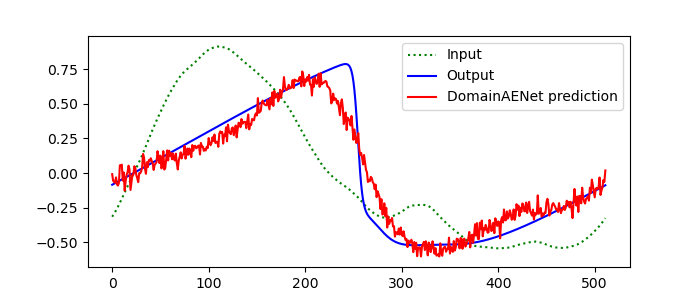

In [ ]:
dae.plot_operator()

In [ ]:
# Setup code

import datetime
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pickle
from sklearn.decomposition import PCA
import ipywidgets as widgets

import models
import utils

%matplotlib widget

plt.rcParams["figure.figsize"] = (7, 3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = utils.DynamicData(("../datasets/burgers/grfarc2visc0p001-coeffs.mat", "grfarc2visc0p001"))
#dataset = utils.DynamicData(("../datasets/transport/hats2_2500.mat", "alldata"))
#dataset = utils.DynamicData(("../datasets/kdv/kdv2.mat", "kdv2wide"))
dataset.shuffle_inplace()

dataset.downsample(2)
dataset.scaledown()

d = dataset.data.shape[-1]
k = 2
width = 500
depth = 3
vecDomain = [d] + ([width] * depth) + [k]
vecRight = [k] + ([width] * depth) + [d]
epochs = 500

t1 = dataset.data.shape[1] - 1

daet = models.DAETimeNet()
daet.setup_data(dataset, int(len(dataset) * 0.8), batch_size=64, t0=0, t1=t1)
daet.setup_aeDomain(vecDomain)
outAE = daet.train_aeDomain(epochs)
#projected = dae.aeDomain(torch.tensor(dae.testarray[:, :d]).to(device)).cpu().detach().numpy()
#projerr = np.mean([np.linalg.norm(projected[j, :] - dae.testarray[j, :d]) / np.linalg.norm(dae.testarray[j, :d]) for j in range(dae.testarray.shape[0])])
projerr = daet.get_projerr()

#daet.setup_right(vecRight)
#outRight = daet.train_right(epochs*2)
#outae = dae.get_operr()
#operr = np.mean([np.linalg.norm(outae[j, :] - dae.testarray[j, d:]) / np.linalg.norm(dae.testarray[j, d:]) for j in range(outae.shape[0])])
operr = daet.get_operr()

print("projection error", projerr, "operator error", operr)

trainarray.shape (2000, 10, 512) testarray.shape (500, 10, 512)
1517514
Starting training domain at Wed Jan 31 16:38:59 2024...
1: Train Loss 2.371e-02 , Relative Projection Error (1, 2, inf): 0.272599, 0.293555, 0.450568
11: Train Loss 6.960e-03 , Relative Projection Error (1, 2, inf): 0.138686, 0.150854, 0.217287
21: Train Loss 2.693e-03 , Relative Projection Error (1, 2, inf): 0.094657, 0.101217, 0.145238
31: Train Loss 1.047e-03 , Relative Projection Error (1, 2, inf): 0.081941, 0.087438, 0.124387


KeyboardInterrupt: 

interactive(children=(IntSlider(value=10, description='j', max=499), IntSlider(value=0, description='t', max=9…

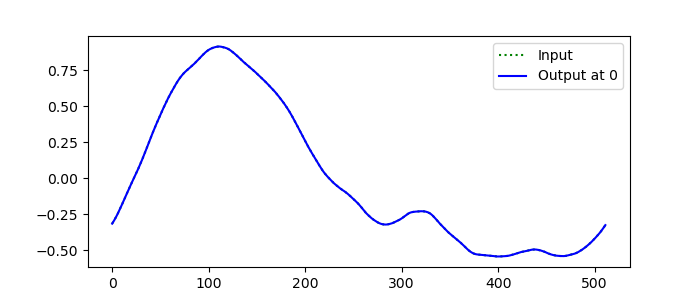

In [ ]:
def plot_operator(daet, arr=None, cuda=False, ylim=None, ord=2):
    if arr is None:
        arr = daet.testarray
        
    projDomain = daet.aeDomain(torch.tensor(arr[:, 0, :]).cuda()).cpu().detach().numpy()

    T = arr.shape[1]
    predicted = []
    for t in range(1, T):
        xx = torch.tensor(arr[:, 0, :])
        tt = torch.ones(xx.shape[0], 1) * t

        domain = torch.concat((xx, tt), 1).to(next(daet.parameters()).get_device())
        rangee = arr[:, t, :]
        operator = daet.forward(domain).cpu().detach().numpy()
        predicted.append(operator)
    
    fig, ax = plt.subplots()
    
    @widgets.interact(j=(0, projDomain.shape[0] - 1), t=(0, T-1))
    def plot_operator_interactive(j=10, t=0):
        print("Domain Encoding Error", np.linalg.norm(projDomain[j, :] - arr[:, 0, :]) / np.linalg.norm(arr[:, 0, :]))
        
        if t > 0:
            print("Operator Error",  np.linalg.norm(predicted[t-1][j, :] - arr[j, t, :]) / np.linalg.norm(arr[j, t, :]))
        
        ax.clear()
        ax.plot(arr[j, 0, :], 'g:', label="Input")
        ax.plot(arr[j, t, :], 'b', label=f"Output at {t}")
        if t > 0:
            ax.plot(predicted[t-1][j, :], 'r', label="Prediction")
        ax.legend()
        
        if ylim:
            ax.set_ylim(ylim)

plot_operator(daet)